# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/vecLSTM/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

array([[<AxesSubplot:title={'center':'Flucases'}>,
        <AxesSubplot:title={'center':'Tempave'}>],
       [<AxesSubplot:title={'center':'Rh'}>,
        <AxesSubplot:title={'center':'Holiday'}>]], dtype=object)

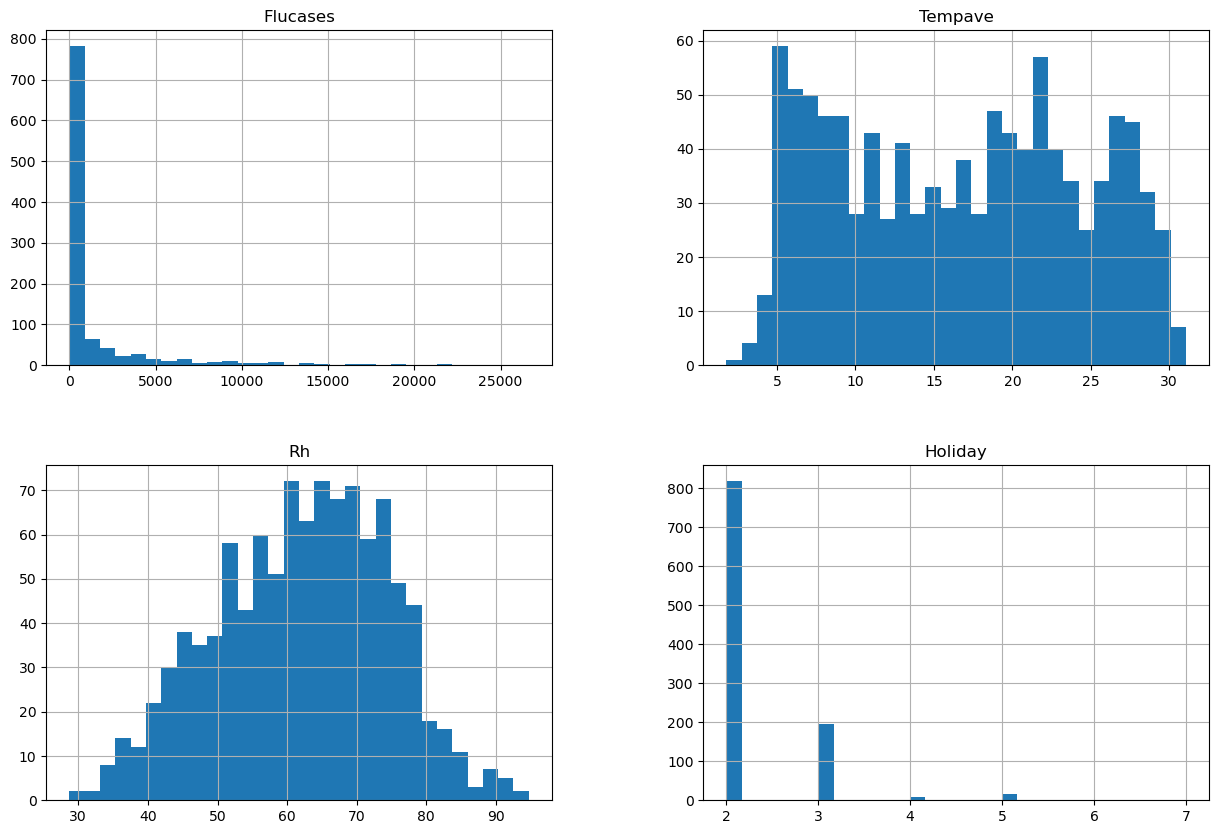

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]
all_data.hist(bins=30, figsize=(15, 10))

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [11]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/vecLSTM/"

In [12]:
seq_length = 1

train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [13]:
train_Xs.shape, train_ys.shape

((779, 1, 4), (779, 1, 4))

In [14]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [15]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [16]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:3])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:3])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:3])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:3])

In [17]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([623, 1, 3]),
 torch.Size([623, 1, 3]),
 torch.Size([156, 1, 3]),
 torch.Size([156, 1, 3]))

In [18]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [19]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
1 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
2 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
3 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
4 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
5 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
6 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
7 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
8 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
9 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
10 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
11 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
12 torch.Size([23, 1, 3]) torch.Size([23, 1, 3])


In [20]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
1 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
2 torch.Size([50, 1, 3]) torch.Size([50, 1, 3])
3 torch.Size([6, 1, 3]) torch.Size([6, 1, 3])


# LSTM model

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        h1 = self.relu(self.fc1(outs))
        h2 = self.fc2(h1)
        y_list = [self.relu(h2[:,0:1]), h2[:,1:3]]
        ys = torch.cat(y_list, dim=1)

        return ys

In [22]:
model = LSTM(input_size = 3, hidden_size = 32, output_size = 3, num_layers = 1)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


## Prediction

In [23]:
batch_0x = list(trn_loader)[0][0]

In [24]:
batch_0x.shape

torch.Size([50, 1, 3])

In [25]:
preds = model(batch_0x)

In [26]:
preds.shape

torch.Size([50, 3])

## Train

In [27]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(3, 32, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [28]:
criterion = nn.MSELoss(reduction='none').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_ys = torch.reshape(trues[:,:,0:3], (trues.shape[0], 3))
            loss = criterion(preds, true_ys).mean(dim=0).mean()
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [30]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_ys = torch.reshape(trues[:,:,0:3], (trues.shape[0], 3))
        loss = criterion(preds, true_ys).mean(dim=0).mean()
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.9557852194859431 Val loss:  0.67430330067873
epoch:  1 Train loss:  0.8683672363941486 Val loss:  0.6087822169065475
epoch:  2 Train loss:  0.7792004025899447 Val loss:  0.490700401365757
epoch:  3 Train loss:  0.5429534155588883 Val loss:  0.3221753519028425
epoch:  4 Train loss:  0.3589705503903903 Val loss:  0.24590475857257843
epoch:  5 Train loss:  0.31259397589243376 Val loss:  0.22263172268867493
epoch:  6 Train loss:  0.3009321643755986 Val loss:  0.2188093326985836
epoch:  7 Train loss:  0.27515458372923046 Val loss:  0.21536093205213547
epoch:  8 Train loss:  0.2593972682952881 Val loss:  0.2008308470249176
epoch:  9 Train loss:  0.23509049300964063 Val loss:  0.19164128601551056
epoch:  10 Train loss:  0.21235072383513817 Val loss:  0.18368567526340485
epoch:  11 Train loss:  0.22590720653533936 Val loss:  0.17798864841461182
epoch:  12 Train loss:  0.20310284655827743 Val loss:  0.17494284734129906
epoch:  13 Train loss:  0.2002328301851566 Val loss

epoch:  112 Train loss:  0.17012833402707025 Val loss:  0.15031536482274532
epoch:  113 Train loss:  0.1725419839987388 Val loss:  0.15129373781383038
epoch:  114 Train loss:  0.1665853628745446 Val loss:  0.15235312841832638
epoch:  115 Train loss:  0.167924158848249 Val loss:  0.154154977761209
epoch:  116 Train loss:  0.1716798463693032 Val loss:  0.1522670742124319
epoch:  117 Train loss:  0.17091236722010833 Val loss:  0.1514072921127081
epoch:  118 Train loss:  0.1708992857199449 Val loss:  0.1505982419475913
epoch:  119 Train loss:  0.16676545143127441 Val loss:  0.15243514068424702
epoch:  120 Train loss:  0.167936368057361 Val loss:  0.14996078424155712
epoch:  121 Train loss:  0.1734286775955787 Val loss:  0.15338639728724957
epoch:  122 Train loss:  0.17312362388922617 Val loss:  0.15090933348983526
epoch:  123 Train loss:  0.1713242886158136 Val loss:  0.15117473155260086
epoch:  124 Train loss:  0.16791343918213478 Val loss:  0.15886867325752974
epoch:  125 Train loss:  0.

epoch:  223 Train loss:  0.1639144363311621 Val loss:  0.15704434644430876
epoch:  224 Train loss:  0.1642675485748511 Val loss:  0.15131674706935883
epoch:  225 Train loss:  0.1642297821549269 Val loss:  0.1554352603852749
epoch:  226 Train loss:  0.16507229323570544 Val loss:  0.15247240848839283
epoch:  227 Train loss:  0.16966908826277807 Val loss:  0.15443760342895985
epoch:  228 Train loss:  0.1665361265723522 Val loss:  0.15296753495931625
epoch:  229 Train loss:  0.1669594066647383 Val loss:  0.15449478663504124
epoch:  230 Train loss:  0.1706952744951615 Val loss:  0.1511943256482482
epoch:  231 Train loss:  0.1674535945057869 Val loss:  0.1580936824902892
epoch:  232 Train loss:  0.16750415987693346 Val loss:  0.15665731206536293
epoch:  233 Train loss:  0.16471225367142603 Val loss:  0.15208145510405302
epoch:  234 Train loss:  0.1639733801667507 Val loss:  0.15291800908744335
epoch:  235 Train loss:  0.1653920807517492 Val loss:  0.15350301936268806
epoch:  236 Train loss: 

epoch:  334 Train loss:  0.16570314593040025 Val loss:  0.15446073841303587
epoch:  335 Train loss:  0.16501410993245932 Val loss:  0.15686628129333258
epoch:  336 Train loss:  0.1647557639158689 Val loss:  0.15540027990937233
epoch:  337 Train loss:  0.16335568405114687 Val loss:  0.1567969871684909
epoch:  338 Train loss:  0.16475801972242501 Val loss:  0.15896403044462204
epoch:  339 Train loss:  0.16186773490447265 Val loss:  0.15459060855209827
epoch:  340 Train loss:  0.1659696652339055 Val loss:  0.1548254508525133
epoch:  341 Train loss:  0.1627289429306984 Val loss:  0.15596940275281668
epoch:  342 Train loss:  0.16209932703238267 Val loss:  0.15762934740632772
epoch:  343 Train loss:  0.16146185936836097 Val loss:  0.15521215926855803
epoch:  344 Train loss:  0.16404306544707373 Val loss:  0.15726181492209435
epoch:  345 Train loss:  0.16173319289317498 Val loss:  0.15707205794751644
epoch:  346 Train loss:  0.1617766928214293 Val loss:  0.15359708573669195
epoch:  347 Train 

epoch:  445 Train loss:  0.16437553958250925 Val loss:  0.1575925648212433
epoch:  446 Train loss:  0.16183185978577688 Val loss:  0.1590717202052474
epoch:  447 Train loss:  0.1591701668042403 Val loss:  0.15876865666359663
epoch:  448 Train loss:  0.15800665834775338 Val loss:  0.15806377492845058
epoch:  449 Train loss:  0.1594991787121846 Val loss:  0.15781555604189634
epoch:  450 Train loss:  0.16295291024904984 Val loss:  0.15703162923455238
epoch:  451 Train loss:  0.16125179999149764 Val loss:  0.15689438860863447
epoch:  452 Train loss:  0.1601002371081939 Val loss:  0.16028398647904396
epoch:  453 Train loss:  0.15770310220810083 Val loss:  0.1594902304932475
epoch:  454 Train loss:  0.1581211250561934 Val loss:  0.16157208383083344
epoch:  455 Train loss:  0.16410912859898347 Val loss:  0.15635809861123562
epoch:  456 Train loss:  0.15930253267288208 Val loss:  0.1585241174325347
epoch:  457 Train loss:  0.1579216649899116 Val loss:  0.16244345530867577
epoch:  458 Train los

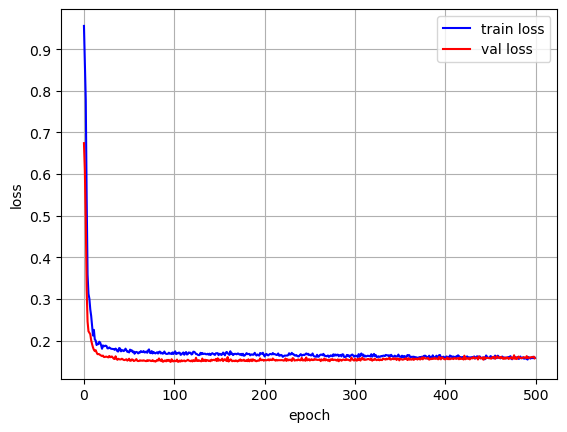

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [32]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(96, 0.1489069452509284)

In [33]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [34]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
np.array(trues_list).shape, np.array(preds_list).shape

((623, 1, 3), (623, 1, 3))

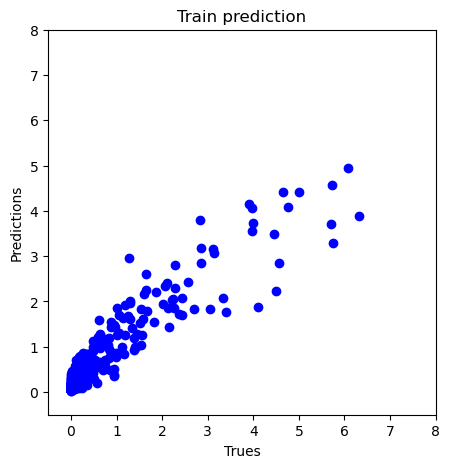

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [37]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155


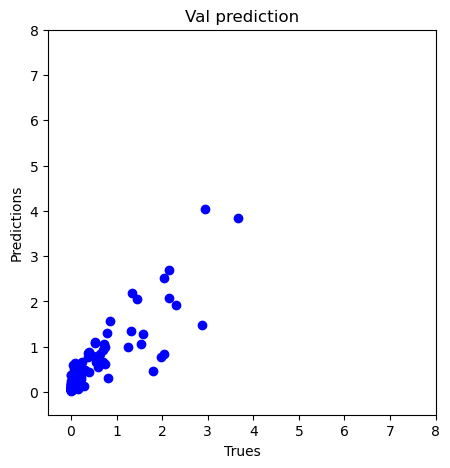

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [39]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [40]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [41]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [42]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [43]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [44]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [45]:
test_all_np.shape

(260, 4)

In [46]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [47]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [48]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [49]:
test_Xs.shape, test_ys.shape

((259, 1, 4), (259, 1, 4))

In [50]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:3])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:3])

In [51]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [52]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258


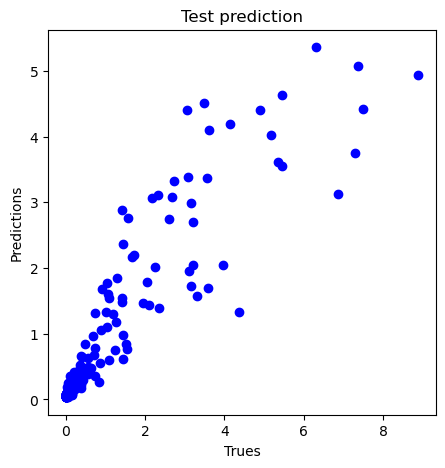

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [54]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [55]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

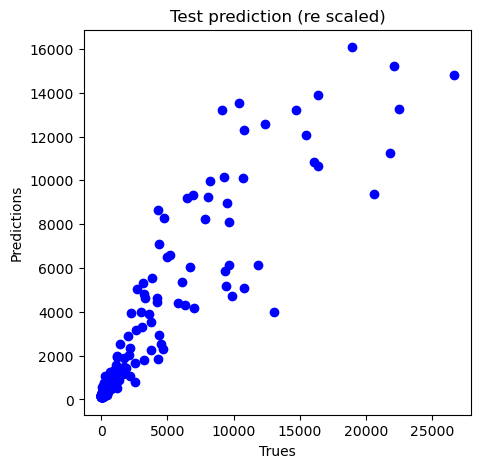

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [57]:
tst_preds.shape

(259, 1)

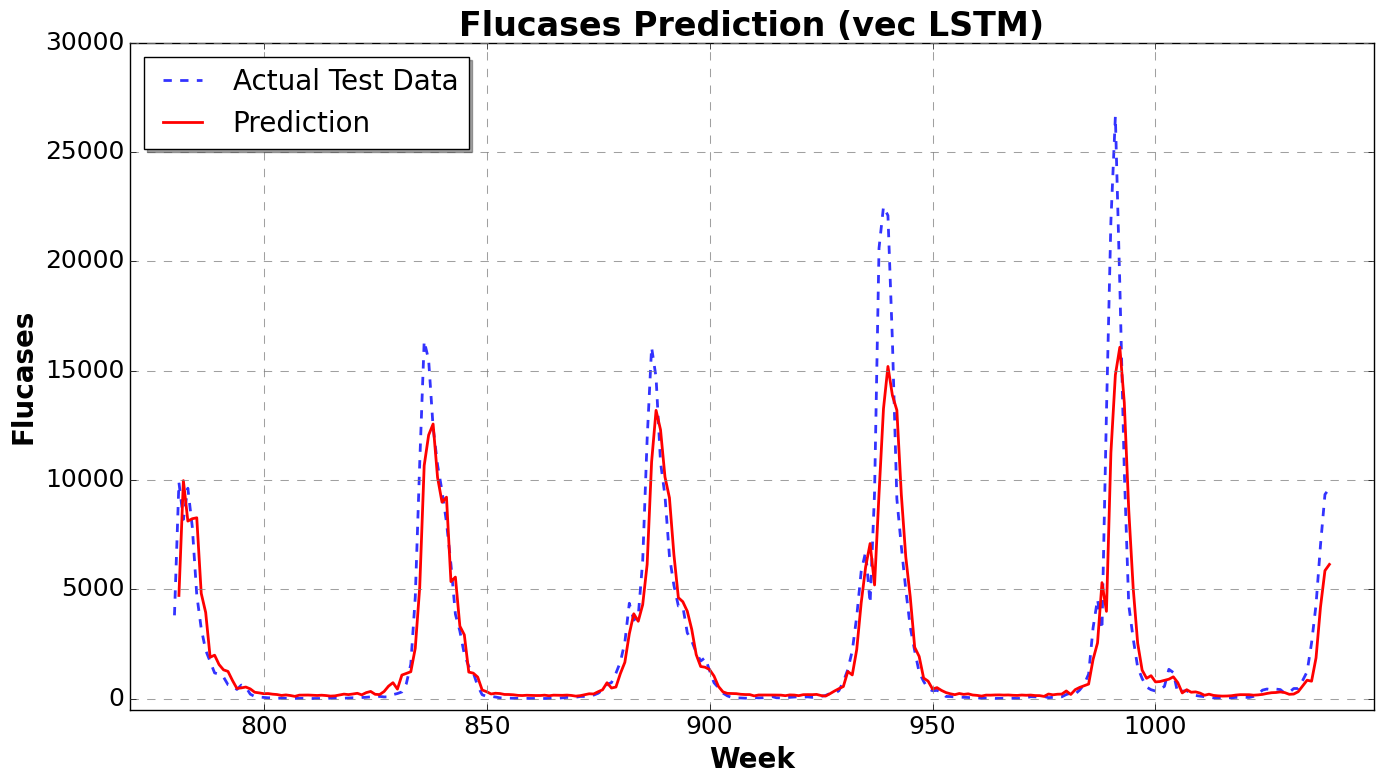

In [58]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (vec LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
#plt.savefig("Flucases Prediction (vec LSTM).jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [59]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [60]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 3804395.5902360315.
RMSE : 1950.485988218329.
MAE : 828.5011552788576.
R2 : 0.8180142591582886.
pearson : 0.9192762645270335 4.630486123532181e-106


In [61]:
reg_metric(test_np[seq_length*52:,0], tst_preds[seq_length*51:,0], "Flucases")

Flucases
MSE : 4478372.16368889.
RMSE : 2116.216473730627.
MAE : 909.100687283736.
R2 : 0.8142778082278137.
pearson : 0.9211819505025043 2.1865671733795707e-86
